# Causes of disambiguation

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr

epsilon = 10e-80

## Let's do disambiguation

In [55]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 's']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = 15

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.01

# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                  strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                  always_learning=always_learning, normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                         mixed_start=mixed_start, contiguous=contiguous)
n_connections = len(seq1) - 1
nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
value = 1.0
alpha = Bs[0]
weights = [value for B in Bs]
weights_collection = [weights, weights]
sequences = [seq1, seq2]
w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=0)

nr = np.concatenate((nr1, nr2))
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

nn.w_ampa = w
w_diff = 2 * alpha
current = 2  * g_w_ampa * w_diff
noise = factor * current
nn.sigma = noise

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.13 ms


s1=  1.0
s2=  1.0


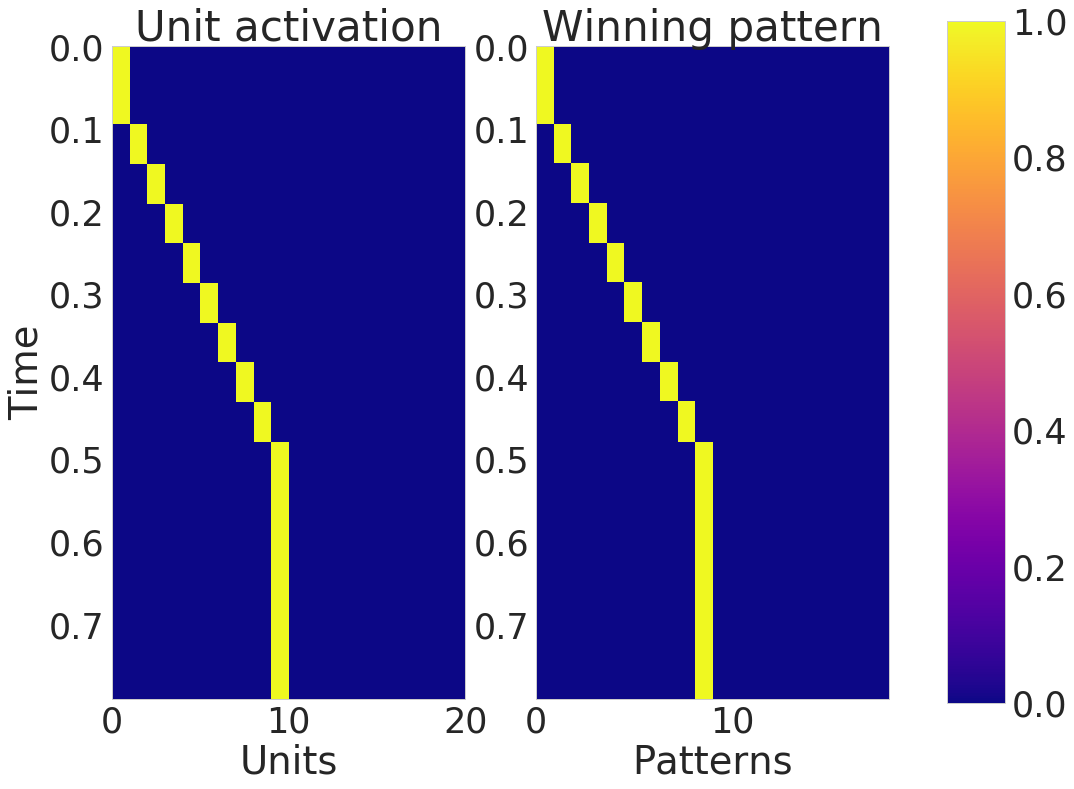

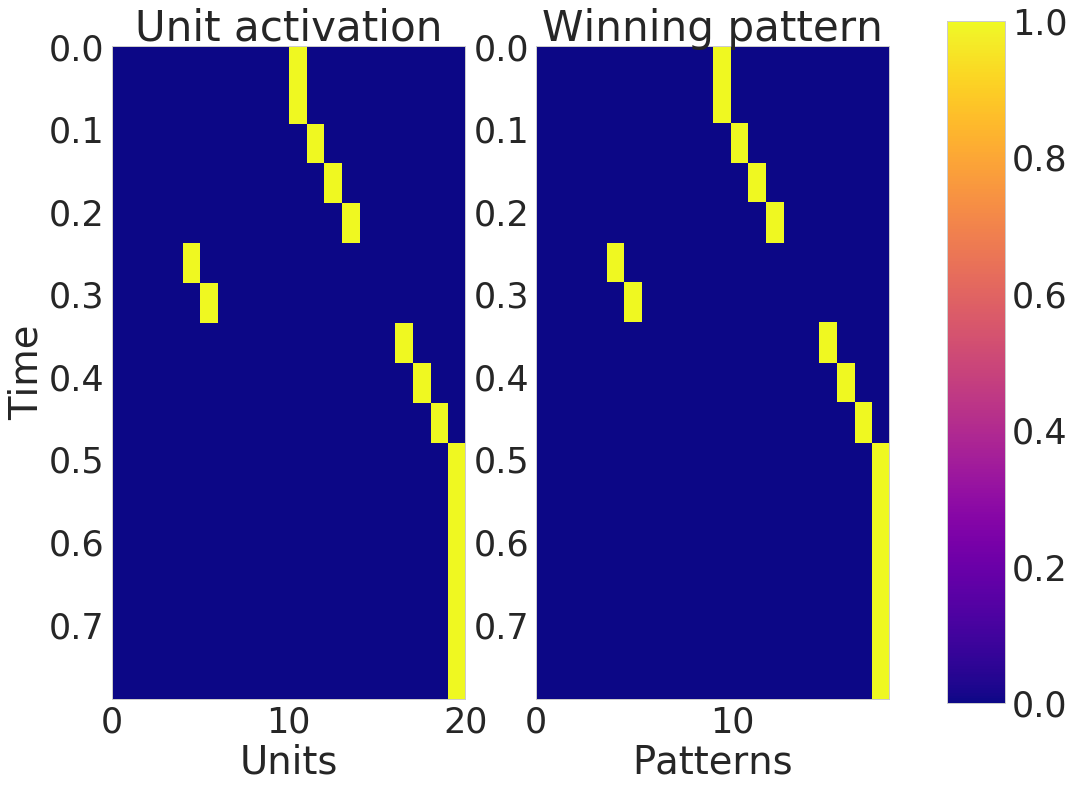

In [56]:
first = True
aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
s, timings, pattern_sequence = aux
print('s1= ', s)
plot_network_activity_angle(manager)
if first:
    s6 = np.copy(manager.history['s'][:, 6])
    s16 = np.copy(manager.history['s'][:, 16])
    time_lists = timings
aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
s, timings, pattern_sequence = aux
print('s2= ', s)
plot_network_activity_angle(manager)
if False:
    s6 = np.copy(manager.history['s'][:, 6])
    s16 = np.copy(manager.history['s'][:, 16])
    time_lists = timings

In [57]:
pattern_sequence

[10, 11, 12, 13, 4, 5, 16, 17, 18, 19]

In [58]:
pprint.pprint(seq1)
pprint.pprint(seq2)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])
array([[10],
       [11],
       [12],
       [13],
       [ 4],
       [ 5],
       [16],
       [17],
       [18],
       [19]])


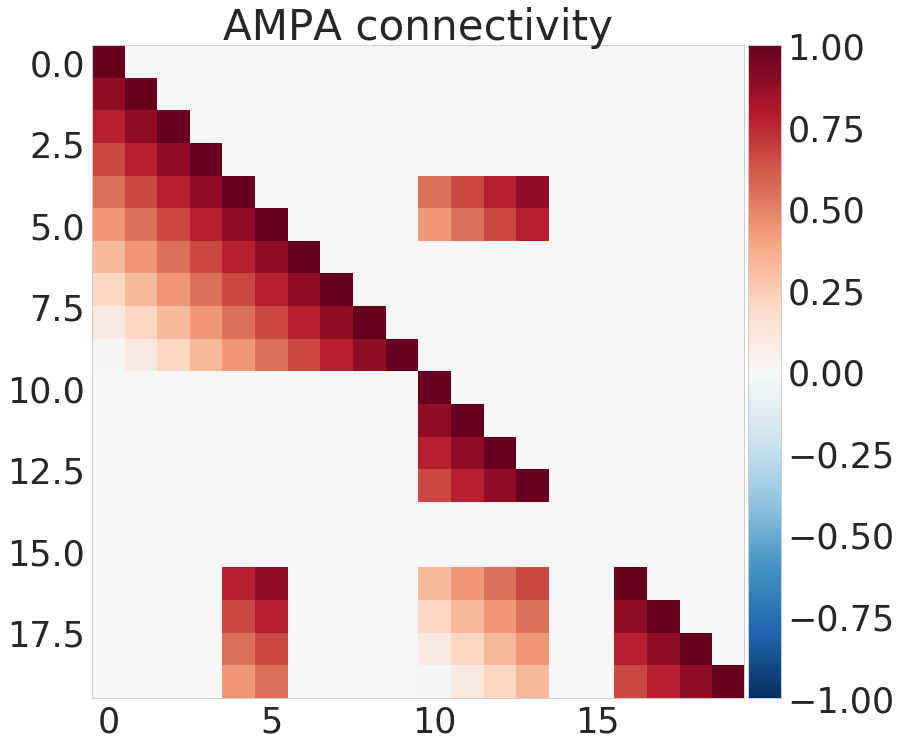

In [59]:
plot_weight_matrix(manager.nn, ampa=True)

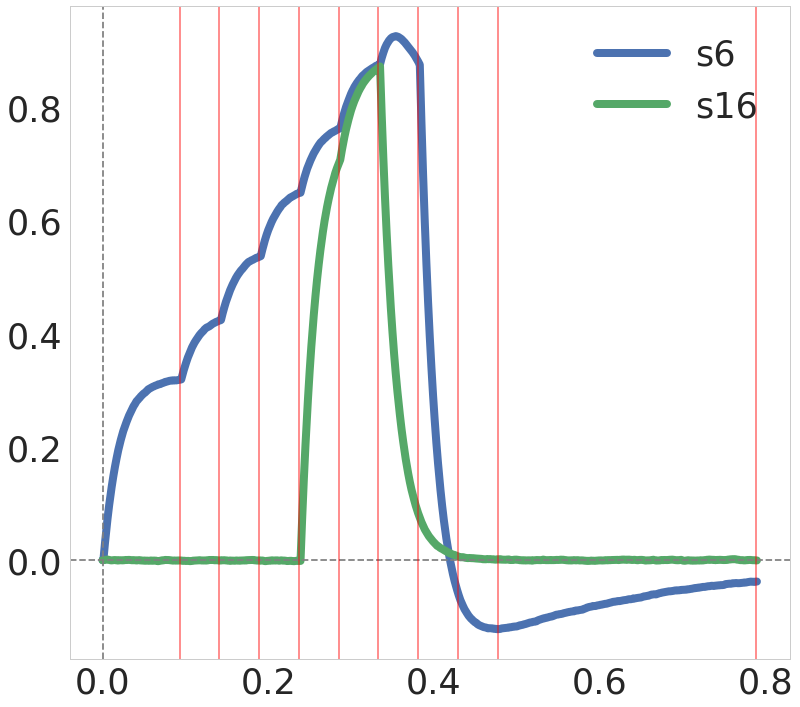

In [60]:
T_stats = [t[3] for t in time_lists]
time = np.linspace(0, manager.T_total, s6.size)
lw = 8

plt.plot(time, s6, lw=lw, label='s6')
plt.plot(time, s16, lw=lw, label='s16')

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

for T_start in T_stats:
    plt.axvline(T_start, ls='-', color='red', alpha=0.5)

plt.legend();

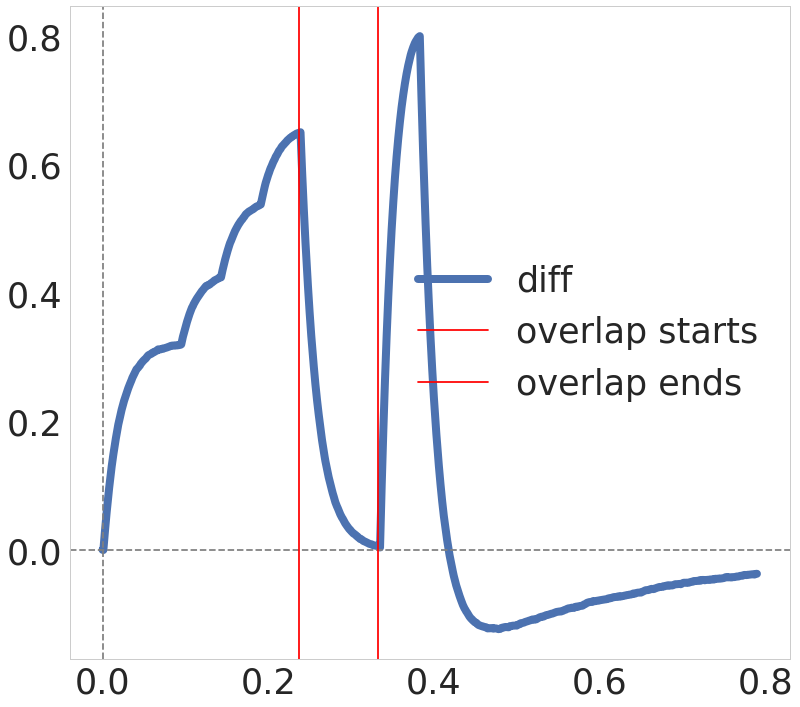

In [61]:
plt.plot(time, s6 - s16, lw=lw, label='diff')
plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')
plt.axvline(T_stats[3], ls='-', color='red', label='overlap starts')
plt.axvline(T_stats[5], ls='-', color='red', label='overlap ends')

plt.legend();

## Tests 

#### Extension

In [16]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.020
T_recall = T_cue + (1.5) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

num = 9
trials = 1
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))
successes = []
extensions = [1, 3, 5, 7, 10]

factor = 0.00

for extension in extensions:
    success_vector = np.zeros((num, trials))

    for r_index, r in enumerate(r_space):
        # Neural Network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                          strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                          always_learning=always_learning, normalized_currents=normalized_currents)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Protocol
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                                 mixed_start=mixed_start, contiguous=contiguous)
        n_connections = len(seq1) - 1
        nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
        nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        value = 1.0
        alpha = Bs[0]
        weights = [value for B in Bs]
        weights_collection = [weights, weights]
        sequences = [seq1, seq2]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10.0)
        
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic
        nn.w_ampa = w
        w_diff = 2 * alpha
        current = 2  * g_w_ampa * w_diff
        noise = factor * current
        nn.sigma = noise
        
        # Recall
        for trial in range(trials):
            aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
            s1, timings, pattern_sequence = aux
            aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
            s2, timings, pattern_sequence = aux
            success_vector[r_index, trial] = 0.5 * (s1 + s2)
            
    successes.append(np.copy(success_vector))

CPU times: user 8.38 s, sys: 0 ns, total: 8.38 s
Wall time: 8.42 s


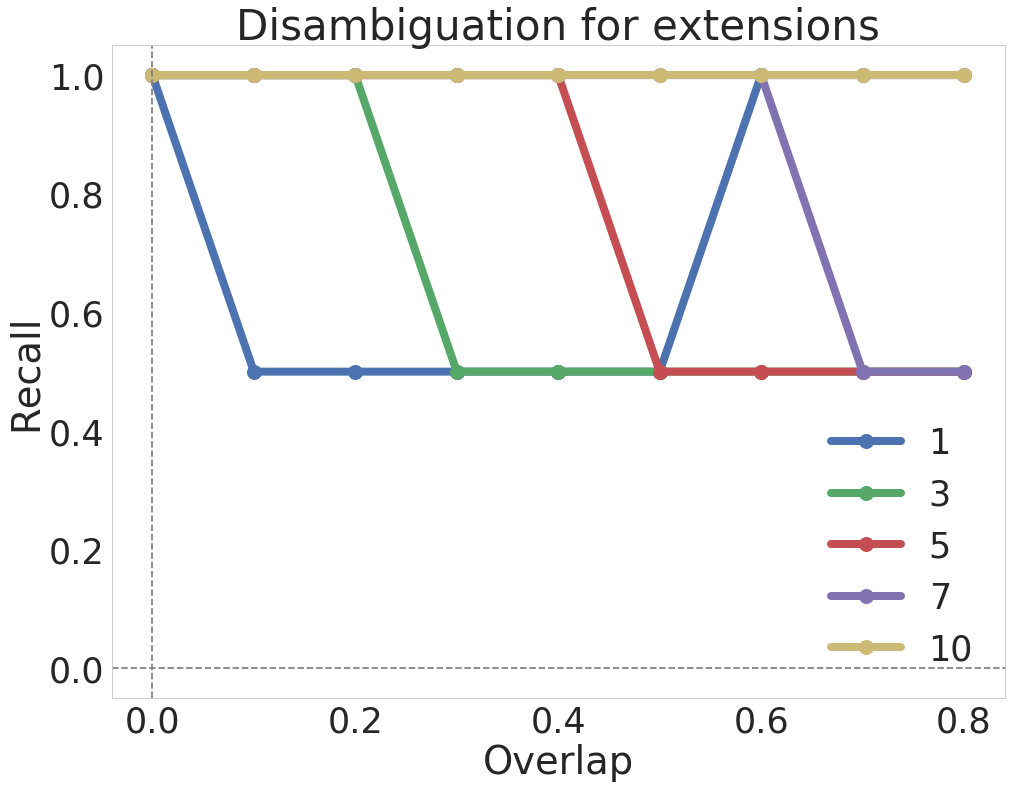

In [17]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
index = 0
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize, label=str(extensions[index]))
    ax.fill_between(r_space, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation for extensions')

ax.legend();

#### tau_m

In [18]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

num = 9
trials = 1
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))
successes = []
factor = 0.0
tau_m_list = [0.001, 0.005, 0.010, 0.020]

for tau_m in tau_m_list:
    T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
    T_persistence = max(0.005, T_persistence - tau_m)
    dt = min(0.001, tau_m / 10.0)
    print(dt)
    success_vector = np.zeros((num, trials))

    for r_index, r in enumerate(r_space):
        # Neural Network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                          strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                          always_learning=always_learning, normalized_currents=normalized_currents)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Protocol
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                                 mixed_start=mixed_start, contiguous=contiguous)
        n_connections = len(seq1) - 1
        nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
        nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        value = 1.0
        alpha = Bs[0]
        weights = [value for B in Bs]
        weights_collection = [weights, weights]
        sequences = [seq1, seq2]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10.0)
        
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic
        nn.w_ampa = w
        w_diff = 2 * alpha
        current = 2  * g_w_ampa * w_diff
        noise = factor * current
        nn.sigma = noise
        
        # Recall
        for trial in range(trials):
            aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
            s1, timings, pattern_sequence = aux
            aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
            s2, timings, pattern_sequence = aux
            success_vector[r_index, trial] = 0.5 * (s1 + s2)
            
    successes.append(np.copy(success_vector))

0.0001
0.0005
0.001
0.001
CPU times: user 40.1 s, sys: 16 ms, total: 40.1 s
Wall time: 40.1 s


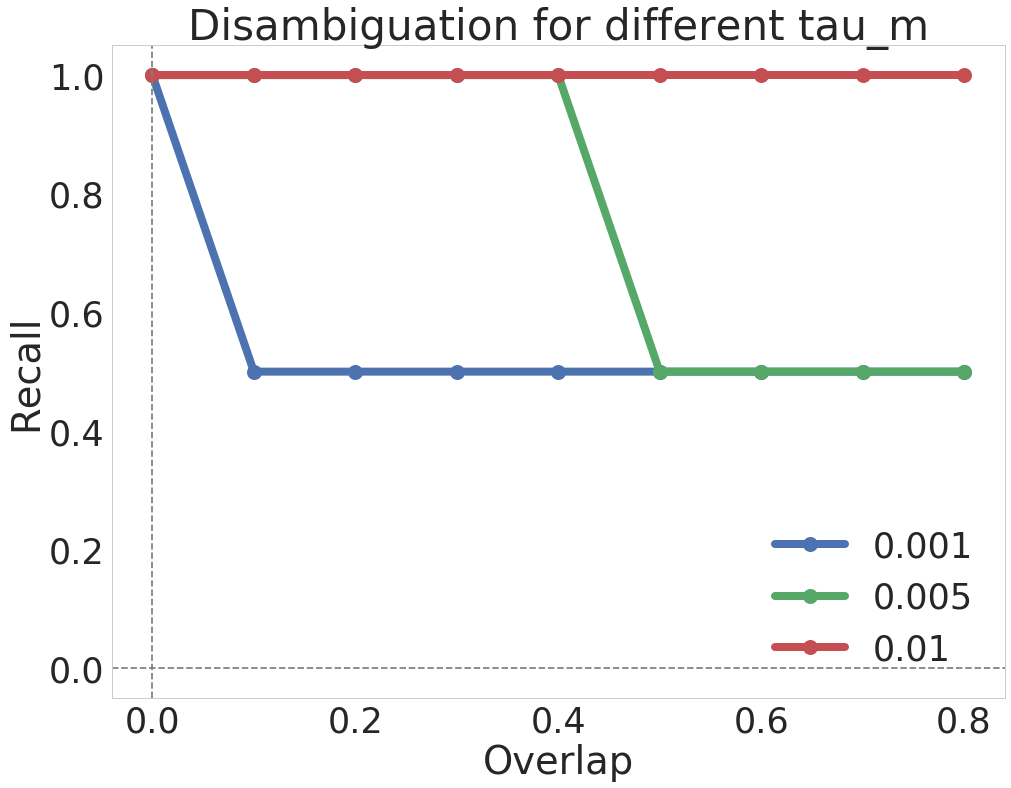

In [19]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
index = 0
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):
    if index < 3:
        mean_success = success_vector.mean(axis=1)
        std = success_vector.std(axis=1)

        ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize, label=str(tau_m_list[index]))
        ax.fill_between(r_space, mean_success - std, mean_success + std,
                            color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation for different tau_m')

ax.legend();

#### Persistent times

In [25]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

num = 9
trials = 1
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))
successes = []
persistence_times = [0.020, 0.100, 0.200]

factor = 0.0

for T_persistence in persistence_times:
    T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
    print('-----------')
    T_persistence = max(0.005, T_persistence - tau_m)
    print(T_recall, T_persistence)
    success_vector = np.zeros((num, trials))

    for r_index, r in enumerate(r_space):
        # Neural Network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                          strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                          always_learning=always_learning, normalized_currents=normalized_currents)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Protocol
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                                 mixed_start=mixed_start, contiguous=contiguous)
        n_connections = len(seq1) - 1
        nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
        nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        value = 1.0
        alpha = Bs[0]
        weights = [value for B in Bs]
        weights_collection = [weights, weights]
        sequences = [seq1, seq2]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10.0)
        
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic
        nn.w_ampa = w
        w_diff = 2 * alpha
        current = 2  * g_w_ampa * w_diff
        noise = factor * current
        nn.sigma = noise
        
        # Recall
        for trial in range(trials):
            aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
            s1, timings, pattern_sequence = aux
            aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
            s2, timings, pattern_sequence = aux
            success_vector[r_index, trial] = 0.5 * (s1 + s2)
            
    successes.append(np.copy(success_vector))

-----------
0.3 0.01
-----------
1.5000000000000002 0.09000000000000001
-----------
3.0000000000000004 0.19
CPU times: user 23.7 s, sys: 12 ms, total: 23.7 s
Wall time: 23.8 s


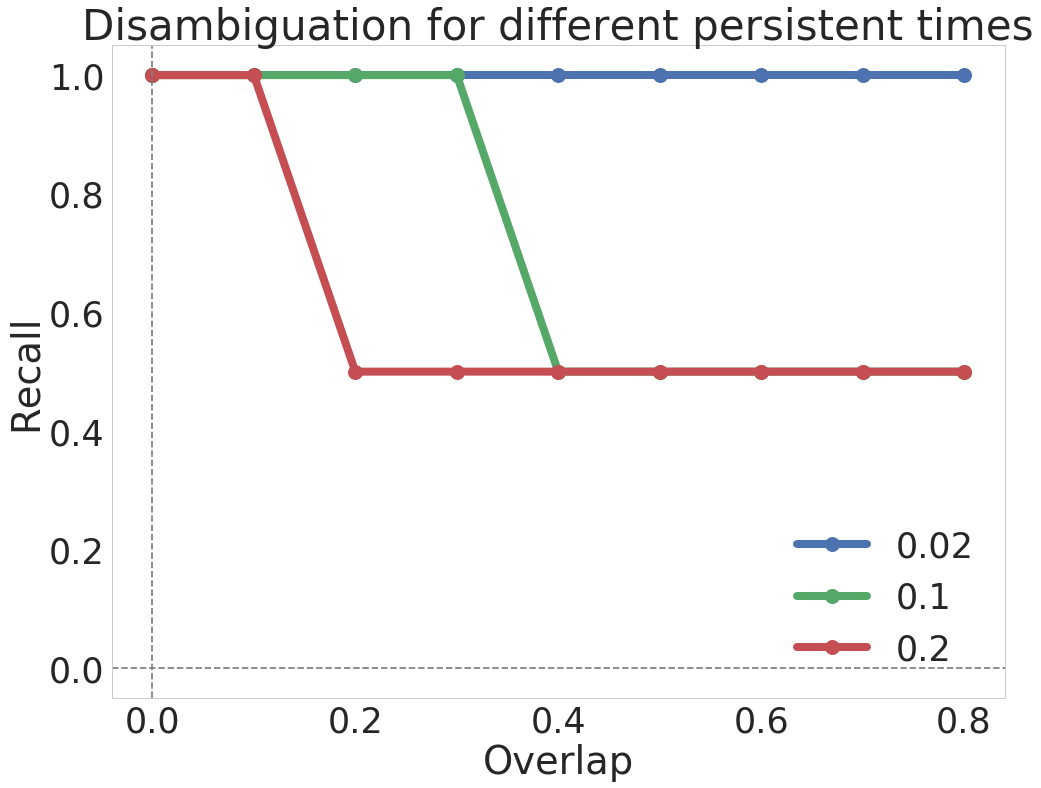

In [26]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
index = 0
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize, label=str(persistence_times[index]))
    ax.fill_between(r_space, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation for different persistent times')

ax.legend();

## It breaks with noise
I want to see that the factors derived from this (0.1, 0.2, 0.3) for noise work in the same way that when I controll the weight directly.

In [31]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 50.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.0
num = 20
trials = 25
factors = np.linspace(0, 1.0, num=num)
success_vector = np.zeros((num, trials))


# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                  strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                  always_learning=always_learning, normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                         mixed_start=False, contiguous=True)
n_connections = len(seq1) - 1
nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
value = 1.0
alpha = Bs[0]
weights = [value for B in Bs]
weights_collection = [weights, weights]
sequences = [seq1, seq2]
w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=-10.0)

nr = np.concatenate((nr1, nr2))
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

nn.w_ampa = w

for index_factor, factor in enumerate(factors):
    w_diff = 2 * alpha
    current = 2  * g_w_ampa * w_diff
    noise = factor * current
    nn.sigma = noise
 
    for trial in range(trials):
        aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=0.020)
        s1, timings, pattern_sequence = aux
        aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=0.020)
        s2, timings, pattern_sequence = aux
        success_vector[index_factor, trial] = 0.5 * (s1 + s2)

CPU times: user 3min 46s, sys: 96 ms, total: 3min 46s
Wall time: 3min 46s


/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


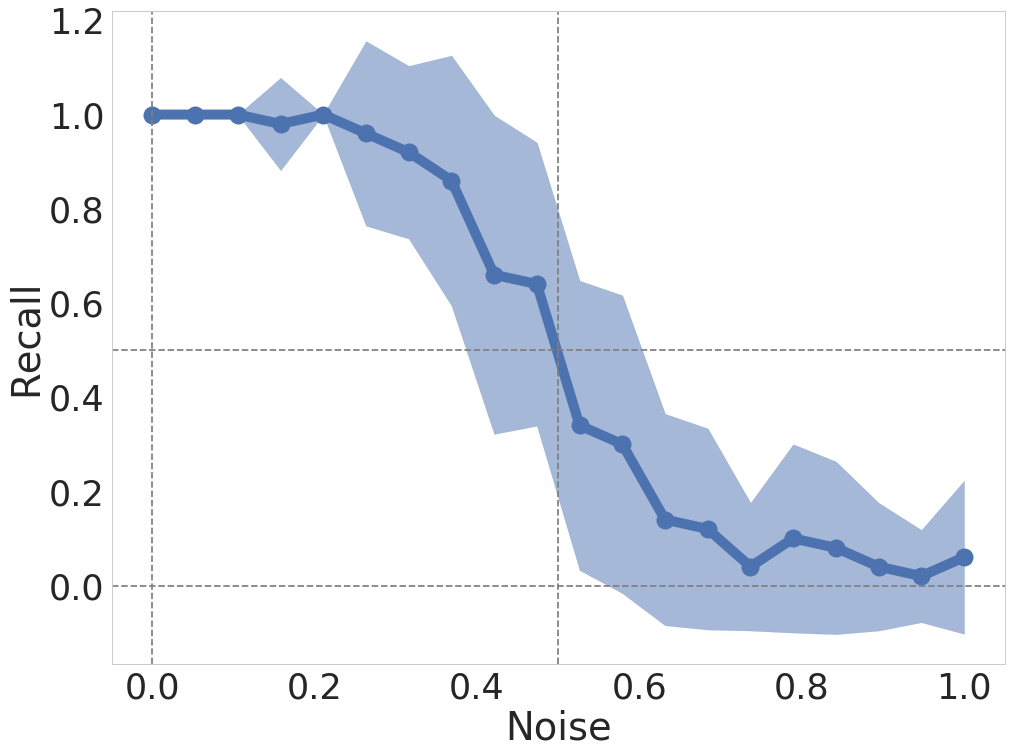

In [32]:
markersize = 18
linewdith = 10
current_palette = sns.color_palette()
index = 0
alpha = 0.5
successes = [success_vector]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(factors, mean_success, 'o-', lw=linewdith, ms=markersize)
    ax.fill_between(factors, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.axvline(0.5, ls='--', color='gray')


ax.set_xlabel('Noise')
ax.set_ylabel('Recall')
ax.legend();

#### Factor 0.1

In [33]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

num = 9
trials = 25
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))
successes = []
factor = 0.1
persistence_times = [0.020, 0.050, 0.100]

for T_persistence in persistence_times:
    T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
    print('-----------')
    T_persistence = max(0.005, T_persistence - tau_m)
    print(T_recall, T_persistence)
    success_vector = np.zeros((num, trials))

    for r_index, r in enumerate(r_space):
        # Neural Network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                          strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                          always_learning=always_learning, normalized_currents=normalized_currents)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Protocol
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                                 mixed_start=mixed_start, contiguous=contiguous)
        n_connections = len(seq1) - 1
        nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
        nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        value = 1.0
        extension = 10
        alpha = Bs[0]
        weights = [value for B in Bs]
        weights_collection = [weights, weights]
        sequences = [seq1, seq2]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10.0)
        
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic
        nn.w_ampa = w
        
        w_diff = 2 * alpha
        current = 2  * g_w_ampa * w_diff
        noise = factor * current
        nn.sigma = noise
        
        # Recall
        for trial in range(trials):
            aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
            s1, timings, pattern_sequence = aux
            aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
            s2, timings, pattern_sequence = aux
            success_vector[r_index, trial] = 0.5 * (s1 + s2)
            
    successes.append(np.copy(success_vector))

-----------
0.3 0.01
-----------
0.7500000000000001 0.04
-----------
1.5000000000000002 0.09000000000000001
CPU times: user 5min 16s, sys: 236 ms, total: 5min 17s
Wall time: 5min 17s


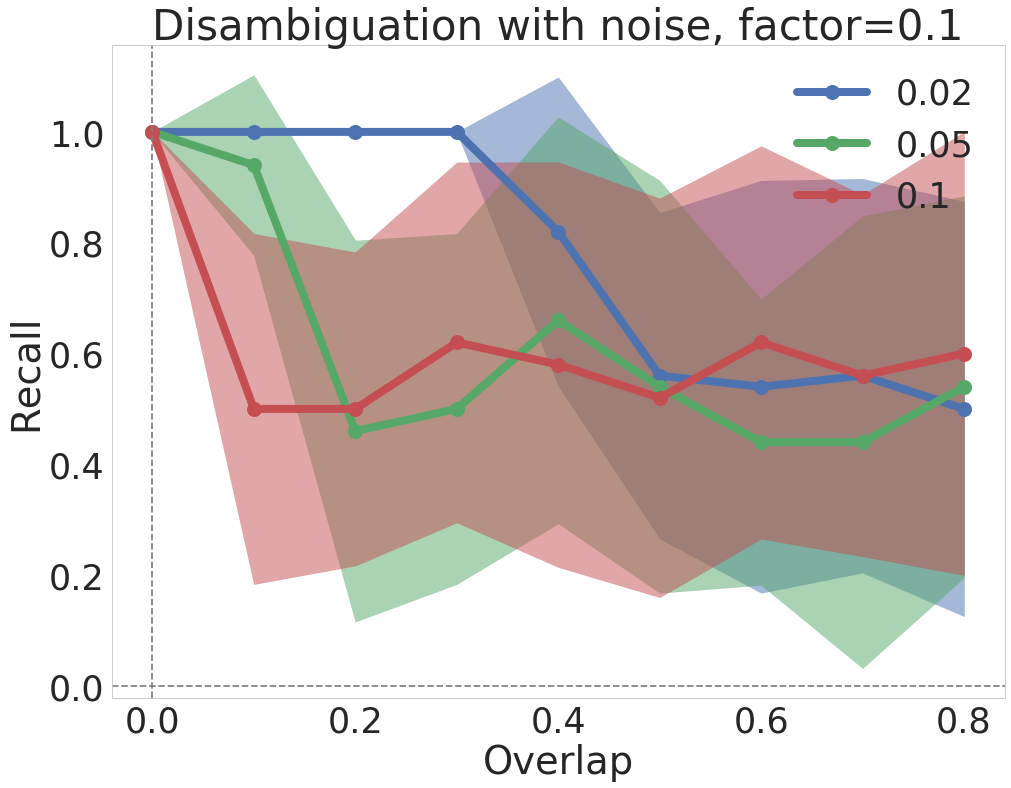

In [34]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
index = 0
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize, label=str(persistence_times[index]))
    ax.fill_between(r_space, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation with noise, factor=' + str(factor))
ax.legend();

#### Factor 0.2

In [35]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.020
T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)


num = 9
trials = 25
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))
successes = []
factor = 0.2
persistence_times = [0.020, 0.050, 0.100]

for T_persistence in persistence_times:
    T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
    print('-----------')
    T_persistence = max(0.005, T_persistence - tau_m)
    print(T_recall, T_persistence)
    success_vector = np.zeros((num, trials))

    for r_index, r in enumerate(r_space):
        # Neural Network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                          strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                          always_learning=always_learning, normalized_currents=normalized_currents)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Protocol
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                                 mixed_start=mixed_start, contiguous=contiguous)
        n_connections = len(seq1) - 1
        nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
        nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        value = 1.0
        alpha = Bs[0]
        weights = [value for B in Bs]
        weights_collection = [weights, weights]
        sequences = [seq1, seq2]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10.0)
        
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic
        nn.w_ampa = w
        
        w_diff = 2 * alpha
        current = 2  * g_w_ampa * w_diff
        noise = factor * current
        nn.sigma = noise
        
        # Recall
        for trial in range(trials):
            aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
            s1, timings, pattern_sequence = aux
            aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
            s2, timings, pattern_sequence = aux
            success_vector[r_index, trial] = 0.5 * (s1 + s2)
            
    successes.append(np.copy(success_vector))

-----------
0.3 0.01
-----------
0.7500000000000001 0.04
-----------
1.5000000000000002 0.09000000000000001
CPU times: user 5min 10s, sys: 184 ms, total: 5min 10s
Wall time: 5min 10s


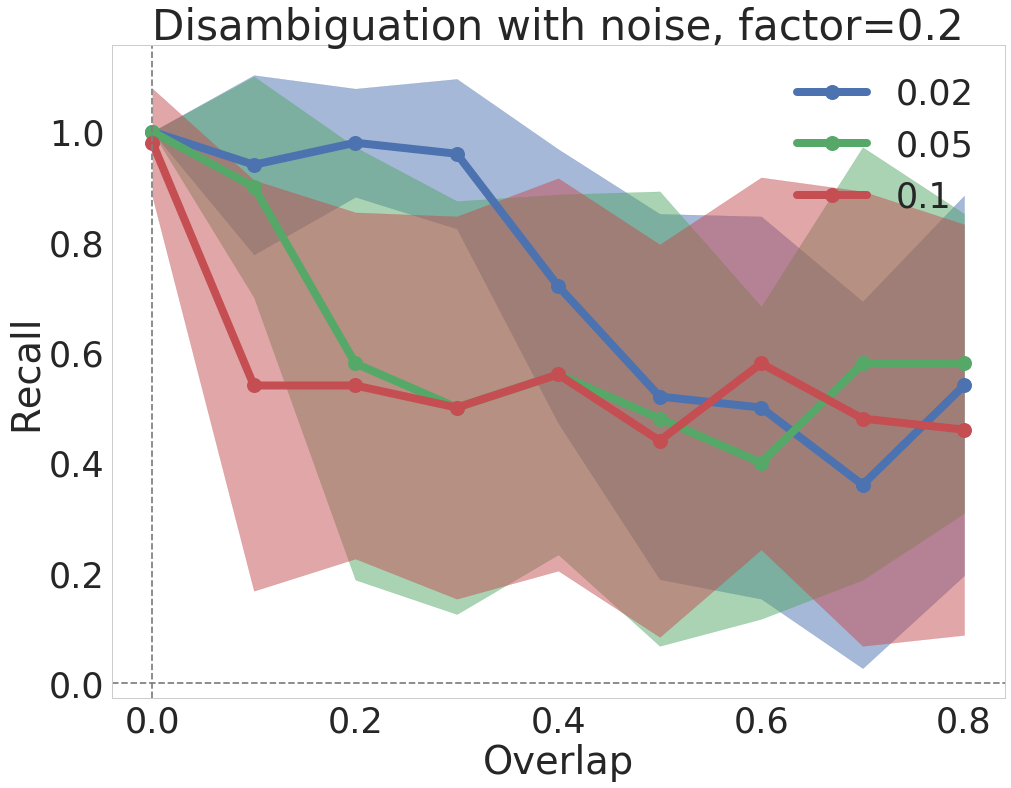

In [36]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
index = 0
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize, label=str(persistence_times[index]))
    ax.fill_between(r_space, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation with noise, factor=' + str(factor))
ax.legend();

## Do you get help by scale

In [39]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.030
T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

num = 9
trials = 10
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))

successes = []
factor = 0.1
extension = n_patterns
success_vector = np.zeros((num, trials))


for r_index, r in enumerate(r_space):
    # Neural Network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                      strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                      always_learning=always_learning, normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Protocol
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                             mixed_start=mixed_start, contiguous=contiguous)
    n_connections = len(seq1) - 1
    nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
    nr2 = build_network_representation(seq2, minicolumns, hypercolumns)
    Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
    value = 1.0
    alpha = Bs[0]
    weights = [value for B in Bs]
    weights_collection = [weights, weights]
    sequences = [seq1, seq2]
    w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                    extension, alpha, w_min=-10.0)

    nr = np.concatenate((nr1, nr2))
    aux, indexes = np.unique(nr, axis=0, return_index=True)
    patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
    manager.patterns_dic = patterns_dic
    nn.w_ampa = w
    w_diff = 2 * alpha
    current = 2  * g_w_ampa * w_diff
    noise = factor * current
    nn.sigma = noise

    # Recall
    for trial in range(trials):
        aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
        s1, timings, pattern_sequence = aux
        aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
        s2, timings, pattern_sequence = aux
        success_vector[r_index, trial] = 0.5 * (s1 + s2)


successes.append(np.copy(success_vector))
print('T_persistence', T_persistence)

T_persistence 0.019999999999999997
CPU times: user 22.6 s, sys: 0 ns, total: 22.6 s
Wall time: 22.6 s


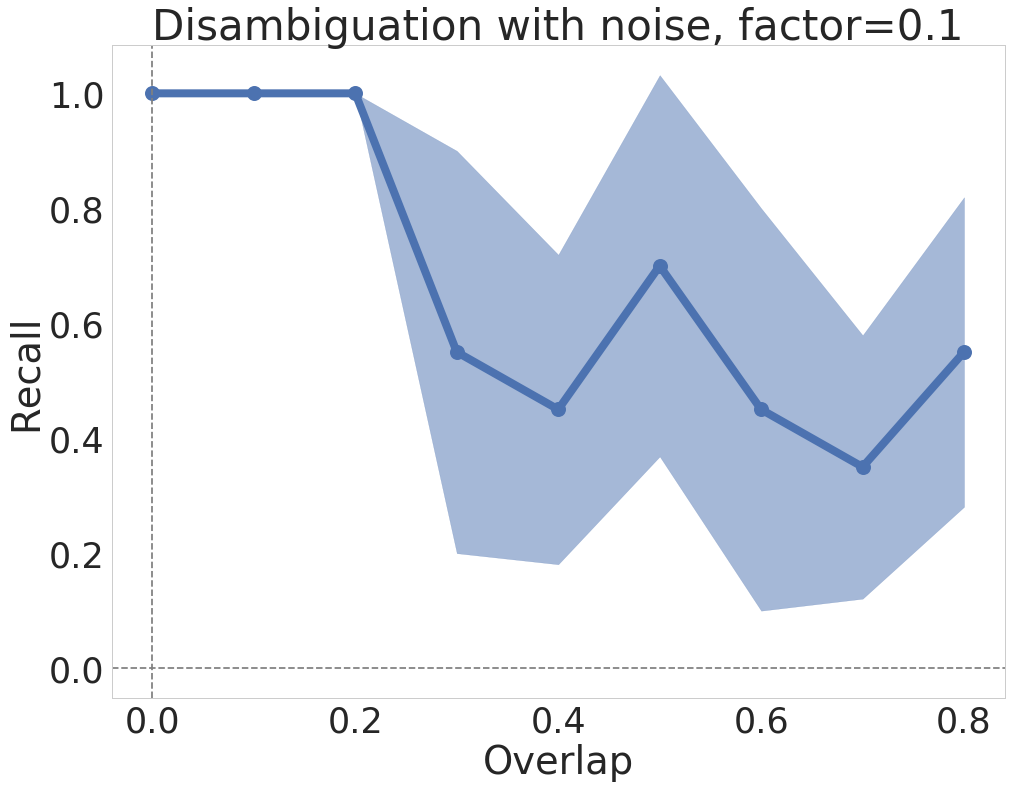

In [40]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
index = 0
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize)
    ax.fill_between(r_space, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation with noise, factor=' + str(factor))
#ax.legend();

#### Test scale

In [41]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.020
T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

num = 9
trials = 10
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))

factor = 0.1
extension = n_patterns
success_vector = np.zeros((num, trials))

hypercolumns_list = [1, 20]
successes = []

for hypercolumns in hypercolumns_list:
    print(hypercolumns)
    for r_index, r in enumerate(r_space):
        # Neural Network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                          strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                          always_learning=always_learning, normalized_currents=normalized_currents)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Protocol
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                                 mixed_start=mixed_start, contiguous=contiguous)
        n_connections = len(seq1) - 1
        nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
        nr2 = build_network_representation(seq2, minicolumns, hypercolumns)
        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        value = 1.0
        alpha = Bs[0]
        weights = [value for B in Bs]
        weights_collection = [weights, weights]
        sequences = [seq1, seq2]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10.0)

        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic
        nn.w_ampa = w
        w_diff = 2 * alpha
        current = 2  * g_w_ampa * w_diff
        noise = factor * current
        nn.sigma = noise

        # Recall
        for trial in range(trials):
            aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
            s1, timings, pattern_sequence = aux
            aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
            s2, timings, pattern_sequence = aux
            success_vector[r_index, trial] = 0.5 * (s1 + s2)

    successes.append(np.copy(success_vector))

1
20
CPU times: user 13min 52s, sys: 30.7 s, total: 14min 22s
Wall time: 3min 54s


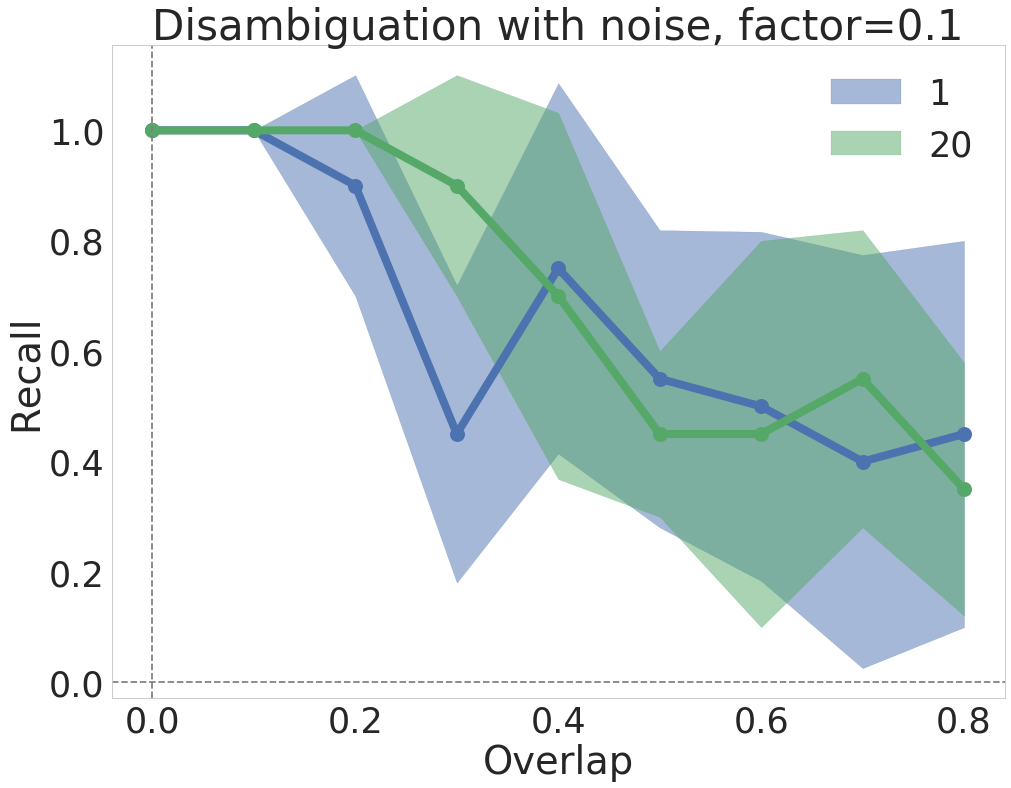

In [42]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize, label=str(hypercolumns_list[index])
    ax.fill_between(r_space, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation with noise, factor=' + str(factor))
ax.legend();

In [46]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.020
T_recall = (1.5 ) * T_persistence * n_patterns / 2.0 
T_persistence = max(0.005, T_persistence - tau_m)

num = 9
trials = 25
r_space = np.linspace(0, 0.8, num=num)
success_vector = np.zeros((num, trials))

factor = 0.1
extension = n_patterns
success_vector = np.zeros((num, trials))

hypercolumns_list = [1, 10, 100]
successes = []

for hypercolumns in hypercolumns_list:
    print(hypercolumns)
    for r_index, r in enumerate(r_space):
        # Neural Network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                          strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                          always_learning=always_learning, normalized_currents=normalized_currents)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Protocol
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                                 mixed_start=mixed_start, contiguous=contiguous)
        n_connections = len(seq1) - 1
        nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
        nr2 = build_network_representation(seq2, minicolumns, hypercolumns)
        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        value = 1.0
        alpha = Bs[0]
        weights = [value for B in Bs]
        weights_collection = [weights, weights]
        sequences = [seq1, seq2]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10.0)

        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic
        nn.w_ampa = w
        w_diff = 2 * alpha
        current = 2  * g_w_ampa * w_diff
        noise = factor * current
        nn.sigma = noise

        # Recall
        for trial in range(trials):
            aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=remove)
            s1, timings, pattern_sequence = aux
            aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=remove)
            s2, timings, pattern_sequence = aux
            success_vector[r_index, trial] = 0.5 * (s1 + s2)

    successes.append(np.copy(success_vector))

1
10
100
CPU times: user 14h 32min 29s, sys: 52min 38s, total: 15h 25min 8s
Wall time: 18h 32min 5s


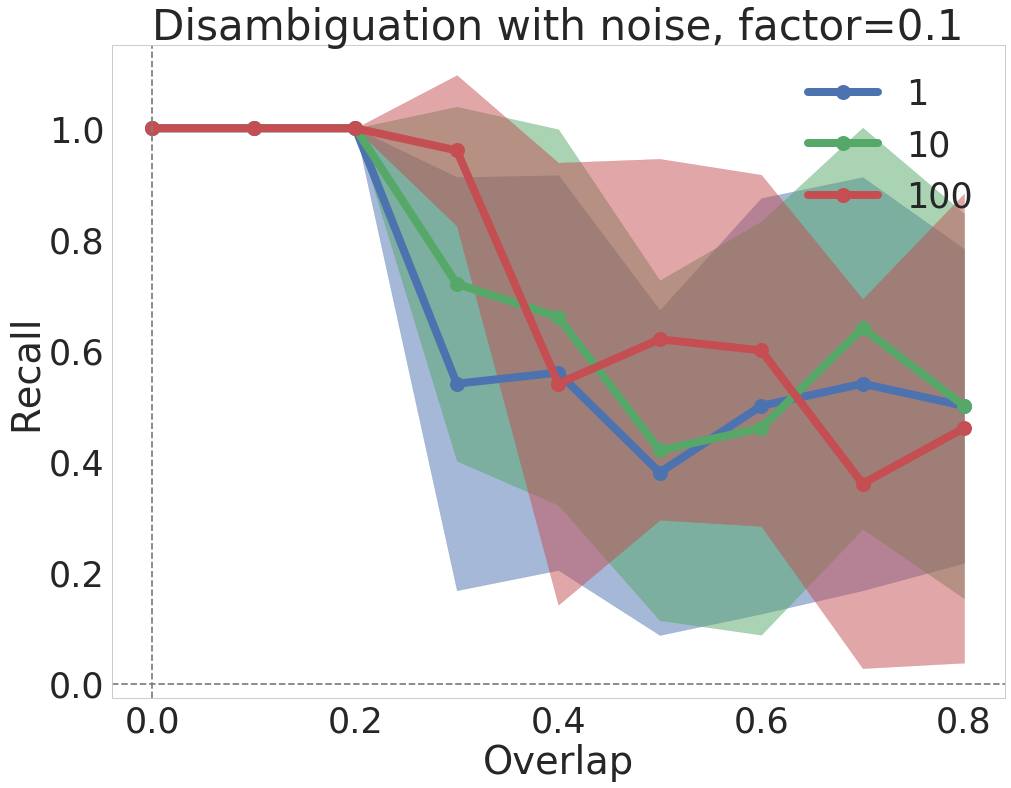

In [47]:
markersize = 15
linewdith = 8
current_palette = sns.color_palette()
alpha = 0.5

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, success_vector in enumerate(successes):

    mean_success = success_vector.mean(axis=1)
    std = success_vector.std(axis=1)

    ax.plot(r_space, mean_success, 'o-', lw=linewdith, ms=markersize, label=str(hypercolumns_list[index]))
    ax.fill_between(r_space, mean_success - std, mean_success + std,
                        color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')
ax.set_title('Disambiguation with noise, factor=' + str(factor))
ax.legend();